In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

# 데이터 다운로드

다운로드 파일 압축풀기

In [13]:
import tarfile

for file in os.listdir('.'):
    if file.endswith('.tar.gz'):
        with tarfile.open(file, 'r:*') as tar_ref:
            tar_ref.extractall('.')
            print(f"{file} 압축 해제 완료")

korean-english-park.dev.tar.gz 압축 해제 완료
korean-english-park.test.tar.gz 압축 해제 완료
korean-english-park.train.tar.gz 압축 해제 완료


k2e_trans_seq2seq.ipynb		korean-english-park.test.ko
korean-english-park.dev.en	korean-english-park.test.tar.gz
korean-english-park.dev.ko	korean-english-park.train.en
korean-english-park.dev.tar.gz	korean-english-park.train.ko
korean-english-park.test.en	korean-english-park.train.tar.gz


In [410]:
import pandas as pd
prefixes = ['dev','test','train']

datasets = {}

for prefix in prefixes:
    ko_path = f'korean-english-park.{prefix}.ko'
    en_path = f'korean-english-park.{prefix}.en'
    
    with open(ko_path, encoding='utf-8') as f_ko, \
         open(en_path, encoding="utf-8") as f_en:
        
        datasets[prefix] = pd.DataFrame({
            'ko': [line.strip() for line in f_ko],
            'en': [line.strip() for line in f_en]
        })
    
print(datasets['train'].head())


                                                  ko  \
0               개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"   
1  모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...   
2                         그러나 이것은 또한 책상도 필요로 하지 않는다.   
3  79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...   
4  정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...   

                                                  en  
0  Much of personal computing is about "can you t...  
1  so a mention a few weeks ago about a rechargea...  
2  Like all optical mice, But it also doesn't nee...  
3  uses gyroscopic sensors to control the cursor ...  
4  Intelligence officials have revealed a spate o...  


In [411]:
print(datasets['dev'].head())

                                                  ko  \
0  세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 ...   
1  초당 12조3천억 번의 계산을 수행할수 있는 능력이 있는 로렌스 리버모아 국립 연구...   
2  미국은 1992년에 지하 핵실험을 중지시켰기 때문에 이러한 모의 실험은 한 치의 오...   
3  에너지省의 핵 안보 차관인 존 고든 장군은 이 수퍼컴퓨터는 "국가의 비축 핵무기를 ...   
4  ASCI White로 알려진 이 수퍼컴퓨터는 놀랄 정도로 엄청나게 많은 용도를 갖고...   

                                                  en  
0  After keeping the world's most powerful superc...  
1  With the ability to perform 12.3 trillion calc...  
2  Those simulations must be as precise as possib...  
3  John Gordon, the Department of Energy's under ...  
4  The supercomputer known as ASCI White has a mi...  


In [412]:
print(datasets['test']['en'].head())

0    Those involved in the discussions do take seri...
1    There is also some hope that new technology de...
2    So the individual solution of the clipper chip...
3    Italian astronomers have found signs of water,...
4    Having water does not mean other planets will ...
Name: en, dtype: object


In [413]:
datasets['train'].info()
datasets['test'].info()
datasets['dev'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94123 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ko      94123 non-null  object
 1   en      94123 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ko      2000 non-null   object
 1   en      2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ko      1000 non-null   object
 1   en      1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


### null 데이터없음

# 데이터 전처리 : 데이터 정제

### 중복데이터 제거

In [414]:
for prefix in ['train', 'dev', 'test']:
    datasets[prefix] = datasets[prefix].drop_duplicates()
    print(f"{prefix} 데이터셋 중복 제거 후: {datasets[prefix].shape}")

train 데이터셋 중복 제거 후: (78941, 2)
dev 데이터셋 중복 제거 후: (1000, 2)
test 데이터셋 중복 제거 후: (1996, 2)


### 영문데이터 전처리 노드함수 사용

In [415]:
def preprocess_sentence_en(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?!,]+", " ", sentence)

    sentence = sentence.strip()
    
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
            
    
    return sentence

### 한글데이터 전처리 함수
"할머니는 자신의 블로그‘라일리의 삶(The Life of Riley)과 ‘유튜브(YouTube)’에 올린 연재한 동영상에는 자신의 매일매일 생활을 명상하는 내용을 담았다."

한국어 데이터에도 영어가 포함되어 있으므로 영어데이터에 대한 전처리도 포함됨

In [416]:
def preprocess_sentence_ko(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글/숫자/기호/영어를 제외한 문자 제거 
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?!, ]+", " ", sentence)
    sentence = sentence.strip()
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'    

    return sentence + ' <end>'  

### 상위 3만개의 데이터 test_corpus 생성

In [417]:
corpus_train_ko = []
corpus_train_en = []



for sentence in datasets["train"]["ko"]:
    corpus_train_ko.append(preprocess_sentence_ko(sentence))

for sentence in datasets["train"]["en"]:
    corpus_train_en.append(preprocess_sentence_en(sentence,s_token=True,e_token=True))

print("English:", corpus_train_en[50000])    
print("한국어:", corpus_train_ko[50000])     

English: <start> asteroid to be harmless fireball over earth <end>
한국어: 원문기사보기 <end>


In [418]:
print("English:", corpus_train_en[50020])    
print("한국어:", corpus_train_ko[50020])   

English: <start> a deputy prime minister who was charged with negotiating with the demonstrators resigned over the crackdown <end>
한국어: 시위대와 교섭을 담당한 총리 보좌관은 이날 강제진압으로 사임했다 <end>


### + 테스트 셋

In [419]:
corpus_test_ko = []
corpus_test_en = []

for sentence in datasets["test"]["ko"]:
    corpus_test_ko.append(preprocess_sentence_ko(sentence))

for sentence in datasets["test"]["en"]:
    corpus_test_en.append(preprocess_sentence_en(sentence,s_token=True,e_token=True))


### 형태소 분리 제약조건
+ 길이를 제한했을 때 영어데이터와 한국데이터의 수가 달라지므로 두 함수를 같이 정의해야 됨 !
+ 한국어 형태소를 분리할 때 sos와 eos의 예외가 필요함

In [420]:
from konlpy.tag import Mecab

mecab = Mecab()

def build_filtered_corpus(eng_sentences, kor_sentences, max_len=40):
    eng_corpus = []
    kor_corpus = []

    for en_sent, ko_sent in zip(eng_sentences, kor_sentences):
        en_tokens = en_sent.split()
        ko_tokens = []

        # 한국어 처리: <start>, <end> 예외 처리 포함
        for word in ko_sent.split():
            if word in ("<start>", "<end>"):
                ko_tokens.append(word)
            else:
                ko_tokens.extend(mecab.morphs(word))
        
        # 조건: 둘 다 길이 제한 이하일 때만 추가
        if len(en_tokens) <= max_len and len(ko_tokens) <= max_len:
            eng_corpus.append(en_tokens)
            kor_corpus.append(ko_tokens)

    return eng_corpus, kor_corpus


In [421]:
filtered_train_en, filtered_train_ko = build_filtered_corpus(corpus_train_en, corpus_train_ko, max_len=40)

print("영어 문장 개수:", len(filtered_train_en))
print("한국어 문장 개수:", len(filtered_train_ko))


영어 문장 개수: 62715
한국어 문장 개수: 62715


In [422]:
print(filtered_train_en[:10])

[['<start>', 'much', 'of', 'personal', 'computing', 'is', 'about', 'can', 'you', 'top', 'this', '?', '<end>'], ['<start>', 'so', 'a', 'mention', 'a', 'few', 'weeks', 'ago', 'about', 'a', 'rechargeable', 'wireless', 'optical', 'mouse', 'brought', 'in', 'another', 'rechargeable', ',', 'wireless', 'mouse', '<end>'], ['<start>', 'like', 'all', 'optical', 'mice', ',', 'but', 'it', 'also', 'doesn', 't', 'need', 'a', 'desk', '<end>'], ['<start>', 'something', 'that', 'will', 'boost', 'their', 'capabilities', 'at', 'crucial', 'moments', 'is', 'very', 'important', '<end>'], ['<start>', 'researchers', 'are', 'already', 'exploring', 'ways', 'to', 'put', 'caffeine', 'in', 'nutrition', 'bars', 'or', 'chewing', 'gum', 'as', 'alternatives', 'to', 'coffee', ',', 'archibald', 'said', '<end>'], ['<start>', 'the', 'institute', 'of', 'medicine', 'is', 'part', 'of', 'the', 'national', 'academy', 'of', 'sciences', ',', 'a', 'private', 'organization', 'chartered', 'by', 'congress', 'to', 'advise', 'the', 'go

In [423]:
filtered_test_en, filtered_test_ko = build_filtered_corpus(corpus_test_en, corpus_test_ko, max_len=40)

print("영어 문장 개수:", len(filtered_test_en))
print("한국어 문장 개수:", len(filtered_test_ko))

영어 문장 개수: 1526
한국어 문장 개수: 1526


# 데이터 토큰화

### 토크나이저 정의

In [424]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=15000,filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, tokenizer

In [425]:
tensor_train_en,tokenize_train_en = tokenize(filtered_train_en)
tensor_train_ko,tokenize_train_ko = tokenize(filtered_train_ko)
tensor_test_en,tokenize_test_en = tokenize(filtered_test_en)
tensor_test_ko,tokenize_test_ko = tokenize(filtered_test_ko)

In [426]:
len(tokenize_train_ko.word_index)

45937

# 모델 설계

### Attention

In [427]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]
        
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

### Encoder

In [428]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length=max_len,mask_zero=True)
        self.gru_layer = tf.keras.layers.GRU(enc_units,  dropout=0.3,return_sequences=True)
        
    def call(self, x):
        x = self.embedding_layer(x)
        output = self.gru_layer(x)
        
        return output

### Decoder

In [429]:
from tensorflow.keras.layers import Dense

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.attention = BahdanauAttention(self.dec_units)  
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length=max_len,mask_zero=True)
        self.decoder_gru = tf.keras.layers.GRU(dec_units, dropout=0.3,return_sequences=True,return_state=True)
        self.ffn = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x, h_dec, enc_out):
        context_vec, atten = self.attention(enc_out,h_dec)

        output = self.embedding_layer(x)
        output = tf.concat([tf.expand_dims(context_vec,1),output], axis=-1)  
        output, h_dec = self.decoder_gru(output)
        output = tf.reshape(output,(-1,output.shape[2]))
        output = self.ffn(output)

        return output, h_dec, atten

### 하이퍼파라미터 설정

In [430]:
BATCH_SIZE     = 64

SRC_VOCAB_SIZE = 15000
TGT_VOCAB_SIZE = 15000

units         = 512
embedding_dim = 256
max_len = 40 
encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

sequence_len = 40


# smaple로 테스트
sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 512)
Decoder Output: (64, 15000)
Decoder Hidden State: (64, 512)
Attention: (64, 40, 1)


### optimizer & loss

In [431]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


In [432]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


# 훈련하기

### 모델 훈련 (테스트)

In [352]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 2

for epoch in range(EPOCHS):
    total_loss = 0
    idx_list = list(range(0, tensor_train_en.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(tensor_train_ko[idx:idx+BATCH_SIZE],
                                tensor_train_en[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                tokenize_train_en)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch  2:  41%|████      | 410/999 [01:21<01:57,  5.03it/s, Loss 3.1890]


KeyboardInterrupt: 

### 실제 테스트

In [433]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 17

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, tensor_train_en.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(tensor_train_ko[idx:idx+BATCH_SIZE],
                                tensor_train_en[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                tokenize_train_en)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0,tensor_test_ko.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(tensor_test_ko[idx:idx+BATCH_SIZE],
                                    tensor_test_en[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    tokenize_test_en)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 17: 100%|██████████| 24/24 [00:01<00:00, 14.47it/s, Test Loss 5.7785]


Raw Input:       커피는 필요 없다.
After Preprocess:커피는 필요 없다 <end>
Prediction:      <start> the end of the story <end>


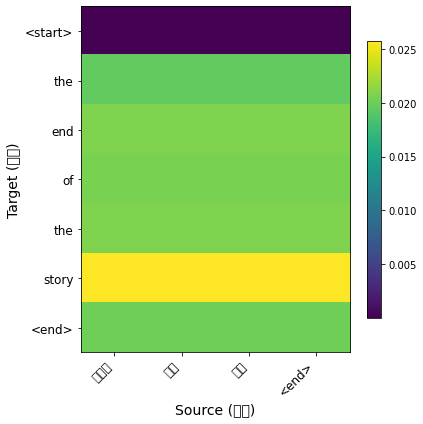

In [440]:
def evaluate(sentence, encoder, decoder):
    # 1) 전처리
    proc = preprocess_sentence_ko(sentence)  
    # 예: "<start> 오바마는 대통령이다 <end>"

    # 2) 시퀀스로 변환 (문자열 리스트!)
    seq = tokenize_train_ko.texts_to_sequences([proc])  # <- [문자열] 형태
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        seq,
        maxlen=tensor_train_ko.shape[-1],  # 훈련 시 max_len
        padding='pre'                      # or 'post', 훈련과 동일하게
    )

    # 3) Tensor로 변환
    inputs = tf.convert_to_tensor(inputs)

    # 4) Encoding
    enc_out = encoder(inputs)          

    # 디코더 초기 상태
    dec_hidden = enc_out[:, -1]        

    # 5) 첫 입력: <start> 토큰
    dec_input = tf.expand_dims([tokenize_train_en.word_index['<start>']], 0)

    result = ''
    attention = np.zeros((tensor_train_en.shape[-1],
                          tensor_train_ko.shape[-1]))

    # 6) 디코딩 루프
    for t in range(tensor_train_en.shape[-1]):
        predictions, dec_hidden, attn_weights = decoder(
            dec_input, dec_hidden, enc_out
        )

        # a) 어텐션 저장
        aw = tf.reshape(attn_weights, (-1,)).numpy()
        attention[t] = aw

        # b) 다음 토큰 예측
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = tokenize_train_en.index_word.get(predicted_id, '<unk>')
        result += predicted_word + ' '

        # c) 종료 조건
        if predicted_word == '<end>':
            break

        # d) 다음 입력 준비
        dec_input = tf.expand_dims([predicted_id], 0)

    return result.strip(), proc, attention


import numpy as np
import matplotlib.pyplot as plt

def plot_attention(attention, input_tokens, output_tokens):
    """
    attention: 2D numpy array, shape=(max_tgt_len, max_src_len)
    input_tokens: 실제 소스 토큰 리스트, 길이 = L_src
    output_tokens: 실제 출력(예측) 토큰 리스트, 길이 = L_tgt
    """

    # 1) 실제 문장 길이에 맞게 슬라이스
    L_tgt = len(output_tokens)
    L_src = len(input_tokens)
    attn = attention[:L_tgt, :L_src]

    # 2) 그림판 크기: 토큰 개수에 비례하여 키우기
    fig, ax = plt.subplots(
        figsize=(max(6, L_src*0.6), max(6, L_tgt*0.6))
    )

    # 3) imshow with auto aspect
    cax = ax.imshow(attn, interpolation='nearest', cmap='viridis', aspect='auto')
    fig.colorbar(cax, shrink=0.8)

    # 4) 틱 위치, 라벨 설정
    ax.set_xticks(np.arange(L_src))
    ax.set_yticks(np.arange(L_tgt))
    ax.set_xticklabels(input_tokens, rotation=45, ha='right', fontsize=12)
    ax.set_yticklabels(output_tokens, fontsize=12)

    # 5) 그리드 켜기 (선택)
    ax.grid(False)
    ax.set_xlabel('Source (입력)', fontsize=14)
    ax.set_ylabel('Target (출력)', fontsize=14)

    plt.tight_layout()
    plt.show()


def translate(sentence, encoder, decoder):
    result, proc, attention = evaluate(sentence, encoder, decoder)
    print(f'Raw Input:       {sentence}')
    print(f'After Preprocess:{proc}')
    print(f'Prediction:      {result}')
    plot_attention(attention, proc.split(), result.split())


translate("커피는 필요 없다.", encoder, decoder)

Raw Input:       시민들은 도시 속에 산다.
After Preprocess:시민들은 도시 속에 산다 <end>
Prediction:      <start> the town hall <end>


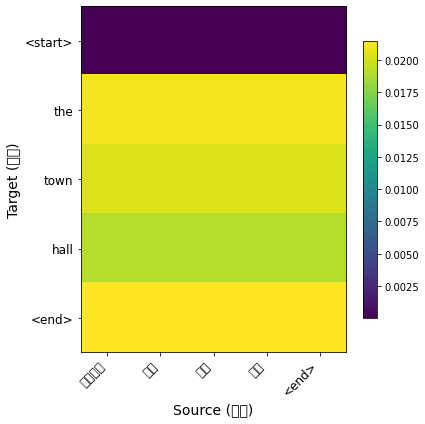

In [441]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Raw Input:       일곱 명의 사망자가 발생했다.
After Preprocess:일곱 명의 사망자가 발생했다 <end>
Prediction:      seven month <end>


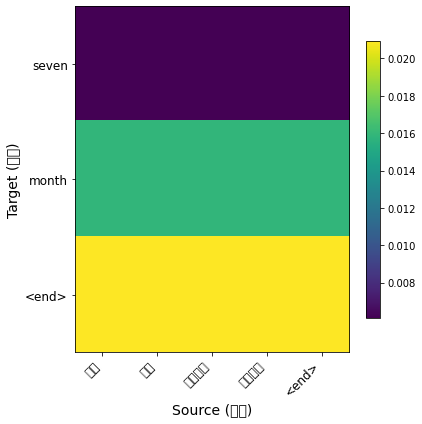

In [442]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Raw Input:       오바마는 대통령이다.
After Preprocess:오바마는 대통령이다 <end>
Prediction:      <start> the u s <end>


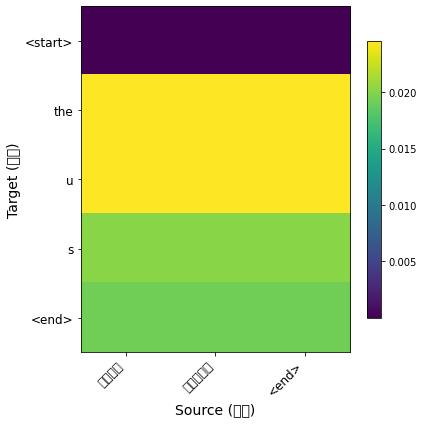

In [443]:
translate("오바마는 대통령이다.", encoder, decoder)

# 회고
생각보다 많은 훈련이 필요했고 복잡했다.
훈련 중 로스가 줄어들지 않고 훈련이 안되고 같은 문장만 출력해내는 이슈가 있었으나
임베딩층에 mask_zero=True로 설정한 뒤 훈련을 하니 로스가 내려갔고 같은 출력만 반복하는 이슈를 해결할 수 있었다.
패딩된 0번 토큰 무시
→ attention, GRU, decoder 모두 "진짜 단어" 위치만 학습

학습에 필요 없는 "패딩 위치 예측"을 안 하게 되었기 때문입니다.

학습 초반에는 모델이 어차피 거의 다 틀리기 때문에
→ 불필요한 패딩 예측까지 더하면서 loss가 3~4 수준에서 정체
→ mask_zero=True를 켠 순간
→ 패딩 토큰들은 완전히 무시되고 실제 의미 있는 위치들만 손실 계산
→ 손실이 의미 있게 줄어들기 시작한다.

위와 같은 이유로 예측을 할 때에는 mask_zero는 필수라는 것을 깨달았다.